In [4]:
!pip install torchtext==0.8.1

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as ttd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [6]:
df = pd.read_csv('/content/train_data_merged_labels.csv', header=0)

from itertools import chain

unique_relations = []
for i in range(0,len(df['Core Relations'])):
  unique_relations.append(df['Core Relations'][i].rsplit('_',1))

unique_relations = list(set(list(chain.from_iterable( unique_relations ))))
print(unique_relations)
 # = chain.from_iterable( df['Core Relations'] )

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder


enc = preprocessing.LabelEncoder()
df['Encoded Relations'] = enc.fit_transform(df['Core Relations'])
df1 = df[['utterances','Encoded Relations']]
df1

['actor.gender', 'movie.initial_release_date_movie.produced', 'movie.estimated', 'movie.directed_by_movie.initial_release', 'movie.directed', 'movie.initial_release_date_movie.production', 'person.date_of', 'companies', 'movie.country_movie.genre', 'movie.locations', 'movie.country_movie.genre_movie.language', 'by', 'movie.gross', 'movie.rating', 'movie.genre', 'movie.initial_release', 'birth', 'movie.music', 'movie.produced_by_movie.production', 'movie.production', 'movie.country', 'budget', 'none', 'movie.genre_movie.gross', 'movie.directed_by', 'movie.subjects', 'movie.production_companies', 'date', 'movie.directed_by_movie.produced', 'movie.starring.character', 'movie.starring.actor', 'movie.directed_by_movie.estimated', 'movie.language', 'movie.genre_movie.production', 'revenue', 'gr.amount_movie.gross', 'movie.initial_release_date', 'movie.genre_movie.initial_release', 'movie.produced']


,utterances,Encoded Relations
0,who plays luke on star wars new hope,42
1,show credits for the godfather,41
2,who was the main actor in the exorcist,41
3,who played dory on finding nemo,42
4,who was the female lead in resident evil,0
...,...,...
2248,revenue for titanic,26
2249,total titanic revenues,26
2250,what was the revenue for toy story 3,26
2251,dark knight revenue,26


In [ ]:
pd.set_option('display.max_rows', 5000)
print(df[['Core Relations','Encoded Relations']][df['Encoded Relations']==16].head(1))
#print(df[['Core Relations','Encoded Relations']][df['Core Relations']=='movie.starring.actor'].head(1))

df2 = pd.read_csv('/content/test_data.csv', header=0)
df2

In [8]:
df1.to_csv('train.csv', index=False)

In [ ]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=True,
    tokenize='spacy',
    use_vocab=True,
    pad_first=False)
LABEL = ttd.Field(sequential=False, use_vocab=False, lower=True, is_target=True)

# Note: if you don't specify use_vocab=False, then PyTorch will
# complain later when you try to iterate over the dataset that
# the attribute `vocab` doesn't exist.

# Note 2: if you don't specify is_target=True, then PyTorch will
# assume it's part of the input, so when you iterate over the
# dataset it will be like:
# for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(
    path='train.csv',
    format='csv',
    skip_header=True,
    fields=[('utterances', TEXT), ('Encoded Relations', LABEL)]
)

In [10]:
train_dataset, test_dataset = dataset.split(split_ratio=0.85) # default is 0.7

In [11]:
TEXT.build_vocab(train_dataset,vectors = 'glove.6B.100d')
LABEL.build_vocab(train_dataset)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18429.95it/s]


In [12]:
vocab = TEXT.vocab

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
train_iter, test_iter = ttd.Iterator.splits(
        (train_dataset, test_dataset), sort_key=lambda x: len(x.utterances),
        batch_sizes=(32, 256), device=device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [25]:
# What is the shape of embedding output?
# N x T x D
embed = nn.Embedding(len(vocab), 20).to(device)
for inputs, targets in train_iter:
  out = embed(inputs)
  print("input shape:", inputs.shape, "output shape:", out.shape)
  break

input shape: torch.Size([32, 11]) output shape: torch.Size([32, 11, 20])


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [26]:
# Define the model
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    # if input is T words
    # then output is (T, D) matrix
    self.embed = nn.Embedding(self.V, self.D)

    # conv layers
    self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding=1)
    
    self.fc = nn.Linear(128, self.K)
  
  def forward(self, X):
    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    out = out.permute(0, 2, 1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    # change it back
    out = out.permute(0, 2, 1)

    # max pool
    out, _ = torch.max(out, 1)

    # final dense layer
    out = self.fc(out)
    return out

In [27]:
model = CNN(len(vocab), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(1064, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [45]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [50]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      # inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      # print("outputs.shape:", outputs.shape)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_iter:
      # inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [55]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 100)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch 1/100, Train Loss: 425.5357,       Test Loss: 11264.3828, Duration: 0:00:00.549601
Epoch 2/100, Train Loss: 678.4753,       Test Loss: 11224.6133, Duration: 0:00:00.401766
Epoch 3/100, Train Loss: 555.1455,       Test Loss: 10750.5865, Duration: 0:00:00.415087
Epoch 4/100, Train Loss: 312.0347,       Test Loss: 10984.5582, Duration: 0:00:00.388560
Epoch 5/100, Train Loss: 405.7820,       Test Loss: 11697.4849, Duration: 0:00:00.397943
Epoch 6/100, Train Loss: 575.2610,       Test Loss: 12522.2000, Duration: 0:00:00.395501
Epoch 7/100, Train Loss: 835.7929,       Test Loss: 11440.0863, Duration: 0:00:00.412357
Epoch 8/100, Train Loss: 967.9634,       Test Loss: 13548.3740, Duration: 0:00:00.422702
Epoch 9/100, Train Loss: 2529.3307,       Test Loss: 18053.5596, Duration: 0:00:00.417785
Epoch 10/100, Train Loss: 1700.7709,       Test Loss: 12934.6702, Duration: 0:00:00.391976
Epoch 11/100, Train Loss: 1956.7690,       Test Loss: 15399.9529, Duration: 0:00:00.389541
Epoch 12/100, Tr

In [56]:
#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    #print(tensor, length_tensor)
    prediction = model(tensor)                  #prediction 
    return prediction.item()           

In [60]:
predict(model = model, sentence="who was the female lead in resident evil")

102.78245544433594

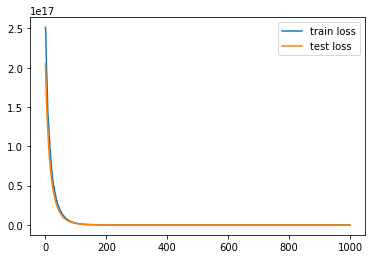

In [53]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9964, Test acc: 0.9450
